In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  Naive, AutoARIMA, AutoCES, AutoTheta, AutoETS
from datasetsforecast.losses import mae
import warnings

In [44]:
warnings.filterwarnings("ignore")

In [45]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close              ...     Volume             
Ticker           BTC-USD         IBM  ...        IBM         NVDA
Date                                  ...                        
2018-01-01  10221.099609  115.116318  ...  151760375  11456216000
2018-02-01  10397.900391  109.582008  ...  107073687  14915528000
2018-03-01   6973.529785  108.956573  ...   98655478  14118440000
2018-04-01   9240.549805  102.941689  ...  128391583  11144008000
2018-05-01   7494.169922  100.349701  ...   92898293  11978240000

[5 rows x 18 columns]

In [46]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,10221.099609,6.079518,115.116318
1,2018-02-01,10397.900391,5.985530,109.582008
2,2018-03-01,6973.529785,5.731612,108.956573
3,2018-04-01,9240.549805,5.566042,102.941689
4,2018-05-01,7494.169922,6.241443,100.349701


In [47]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices


,unique_id,ds,y
0,BTC-USD,2018-01-01,10221.099609
1,BTC-USD,2018-02-01,10397.900391
2,BTC-USD,2018-03-01,6973.529785
3,BTC-USD,2018-04-01,9240.549805
4,BTC-USD,2018-05-01,7494.169922
...,...,...,...
175,IBM,2022-08-01,117.183632
176,IBM,2022-09-01,109.754784
177,IBM,2022-10-01,127.750069
178,IBM,2022-11-01,137.551437


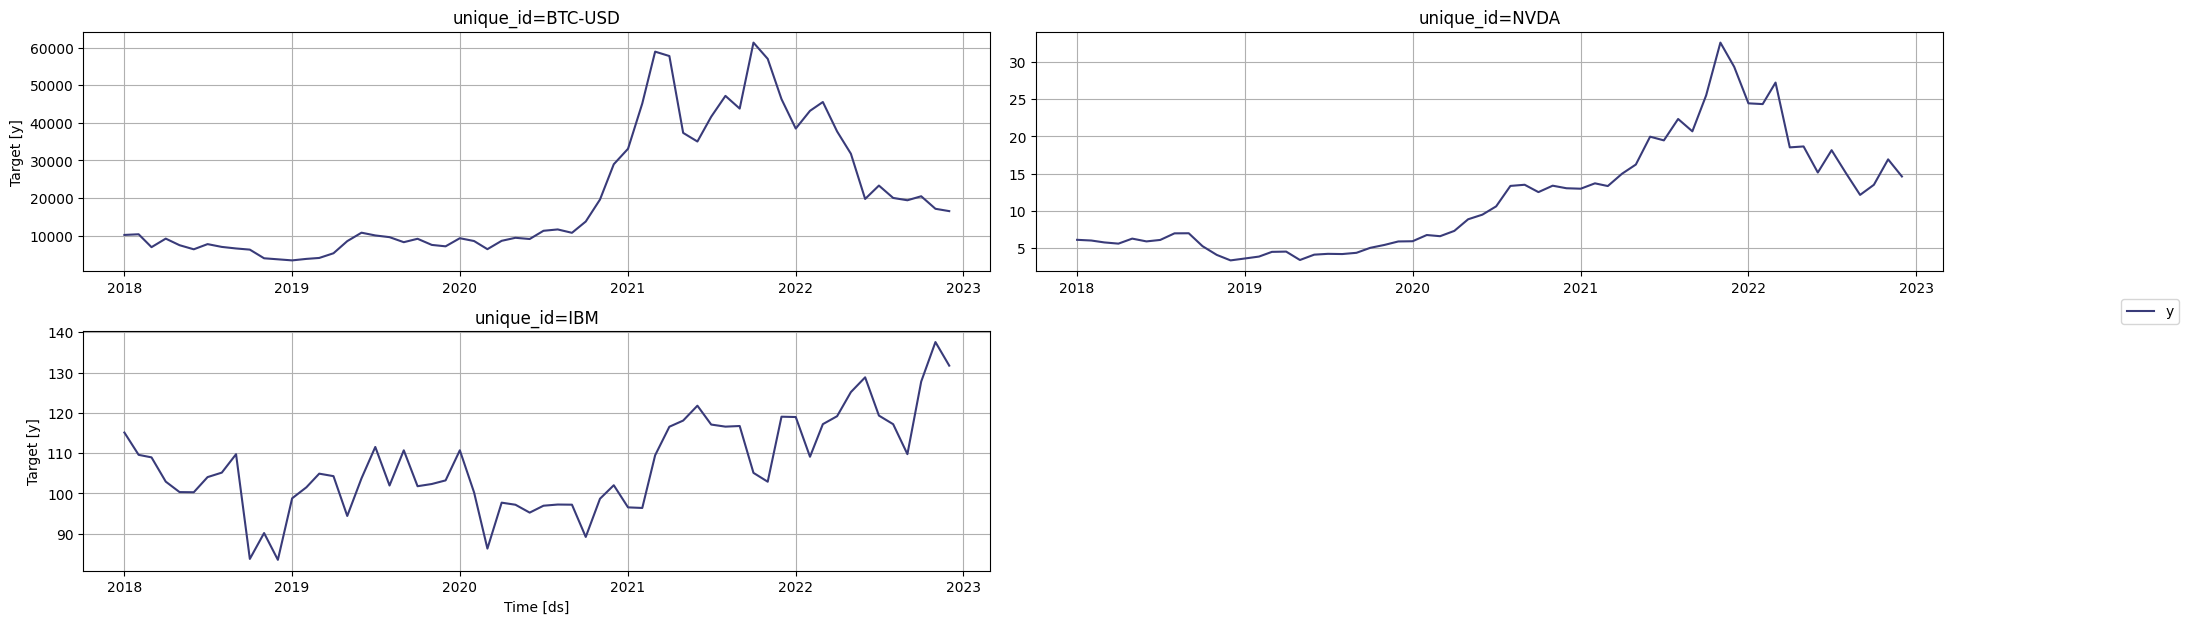

In [48]:
StatsForecast.plot(prices)

In [49]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns = returns.dropna(subset=['y'])
returns

,unique_id,ds,y
1,BTC-USD,2018-02-01,0.017150
2,BTC-USD,2018-03-01,-0.399482
3,BTC-USD,2018-04-01,0.281480
4,BTC-USD,2018-05-01,-0.209476
5,BTC-USD,2018-06-01,-0.157203
...,...,...,...
175,IBM,2022-08-01,-0.018053
176,IBM,2022-09-01,-0.065494
177,IBM,2022-10-01,0.151827
178,IBM,2022-11-01,0.073922


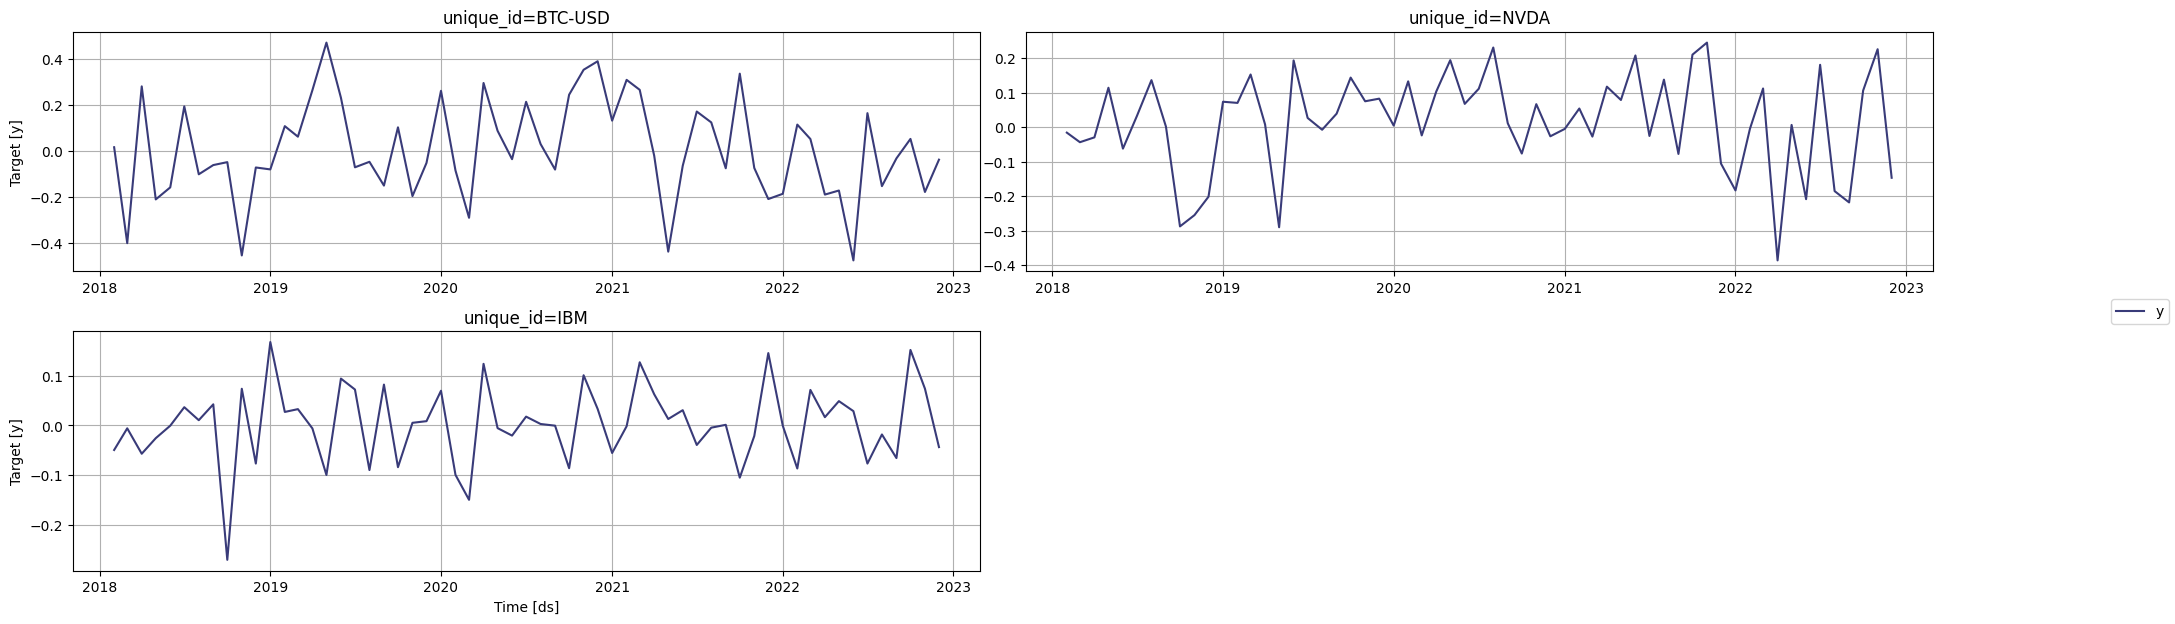

In [50]:
StatsForecast.plot(returns)

In [51]:
models = [Naive(), AutoCES(), AutoETS(), AutoTheta()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

In [52]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [53]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,Naive,CES,AutoETS,AutoTheta
0,BTC-USD,2022-01-01,2021-12-01,-0.185061,-0.207865,-0.028247,0.031990,0.072183
1,BTC-USD,2022-02-01,2021-12-01,0.115464,-0.207865,0.006179,0.031990,0.075082
2,BTC-USD,2022-03-01,2021-12-01,0.052878,-0.207865,0.004978,0.031990,0.077982
3,BTC-USD,2022-04-01,2022-03-01,-0.188507,0.052878,0.007299,0.029796,0.053349
4,BTC-USD,2022-05-01,2022-03-01,-0.170830,0.052878,0.003212,0.029796,0.055456


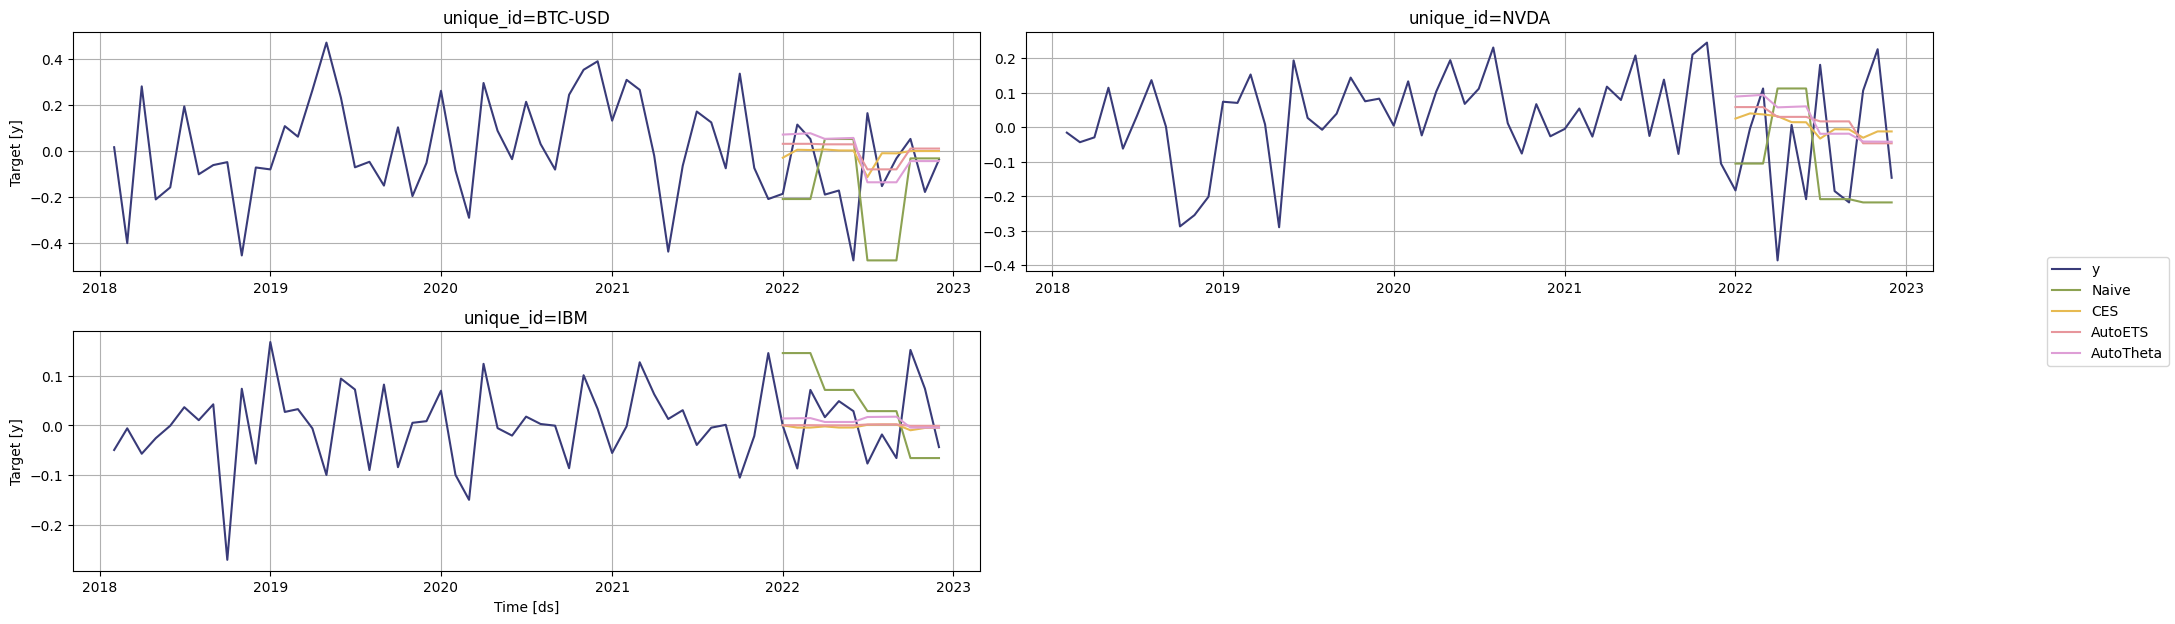

In [54]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [55]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae

,Naive,CES,AutoETS,AutoTheta
unique_id,,,,
BTC-USD,0.270008,0.155980,0.157307,0.165011
IBM,0.099794,0.059018,0.057418,0.060946
NVDA,0.215289,0.174220,0.180208,0.186392
